# Markov Decision Process

## Epsilon-greedy strategy for action selection

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

Defining the reward function

In [2]:
class MovingAverage:
    def __init__(self):
        self.count = 0
        self.value = 0

    def add(self, value):
        num = self.count * self.value + value
        den = self.count + 1
        self.count = self.count + 1
        self.value = num / den
        return self.value

In [3]:
ma = MovingAverage()
for _ in range(10):
    print(ma.add(random.randint(0, 5) + 5))

7.0
6.0
5.666666666666667
5.5
6.0
6.166666666666667
6.142857142857143
6.125
6.444444444444445
6.8


In [4]:
class Bandit:
    def __init__(self, n_arms=10, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.n_arms = n_arms
        self.probs = np.random.random(n_arms)
        self.pulls = np.zeros(self.n_arms)
        self.rewards = np.zeros(self.n_arms)

    def reward(self, prob, n=10):
        reward = 0
        for _ in range(n):
            reward += random.random() < prob
        return reward

    def policy(self):
        return random.randrange(0, self.n_arms)

    def pull(self):
        arm = self.policy()
        reward = self.reward(self.probs[arm])
        pulls = self.pulls[arm]
        mean_reward = self.rewards[arm]
        mean_reward = (pulls * mean_reward + reward) / (pulls + 1)
        self.rewards[arm] = mean_reward
        self.pulls[arm] = pulls + 1

        return mean_reward


class GreedyBandit(Bandit):
    def policy(self, e_greedy=0.2):
        if random.random() < e_greedy:
            arm = random.randrange(0, self.n_arms)
        else:
            arm = np.argmax(self.rewards)
        return arm

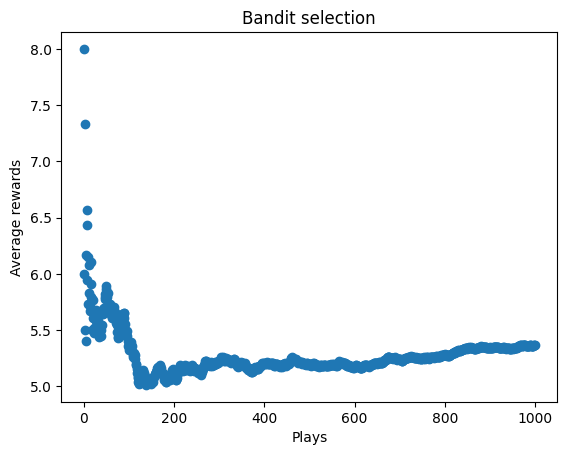

In [5]:
bandit = Bandit(10, seed=42)
trials = 1000
rewards = []
ma = MovingAverage()
for i in range(trials):
    reward = bandit.pull()
    rewards.append(ma.add(reward))

fig, ax = plt.subplots()
ax.scatter(range(trials), rewards)
ax.set_title("Bandit selection")
ax.set_xlabel("Plays")
ax.set_ylabel("Average rewards");

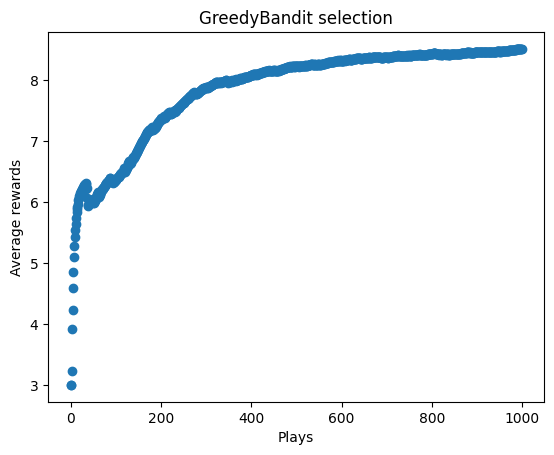

In [6]:
bandit = GreedyBandit(10, seed=42)
trials = 1000
rewards = []
ma = MovingAverage()
for i in range(trials):
    reward = bandit.pull()
    rewards.append(ma.add(reward))

fig, ax = plt.subplots()
ax.scatter(range(trials), rewards)
ax.set_title("GreedyBandit selection")
ax.set_xlabel("Plays")
ax.set_ylabel("Average rewards");

## The softmax function

In [7]:
def softmax(values, tau=1.12):
    num = np.exp(values / tau)
    den = np.sum(num)
    return num / den

In [8]:
from collections import Counter

x = np.arange(10)
p = softmax(x)
n = 1000

choices = []
for _ in range(n):
    choices.append(np.random.choice(x, p=p))
Counter(choices).most_common(5)

[(9, 576), (8, 240), (7, 115), (6, 38), (5, 23)]

In [9]:
softmax(np.zeros(10))

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [10]:
np.round(softmax(np.arange(10)), 3)

array([0.   , 0.   , 0.001, 0.003, 0.007, 0.017, 0.041, 0.099, 0.242,
       0.591])

In [11]:
np.sum(softmax(np.arange(10)))

0.9999999999999999

In [12]:
class SoftmaxBandit(Bandit):
    def policy(self, tau=1.12):
        arms = np.arange(self.n_arms)
        p = softmax(self.rewards, tau=tau)
        arm = np.random.choice(arms, p=p)
        return arm

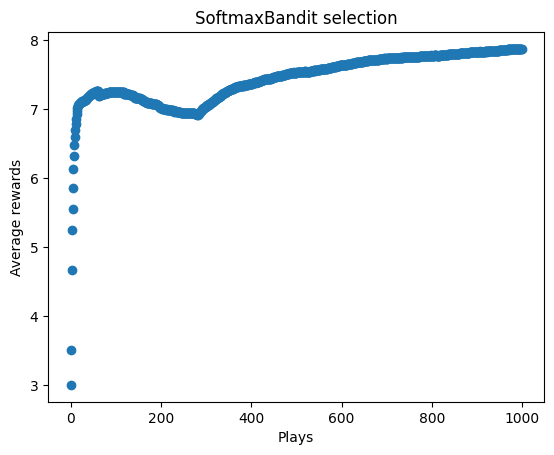

In [13]:
bandit = SoftmaxBandit(10, seed=42)
trials = 1000
rewards = []
ma = MovingAverage()
for i in range(trials):
    reward = bandit.pull()
    rewards.append(ma.add(reward))

fig, ax = plt.subplots()
ax.scatter(range(trials), rewards)
ax.set_title("SoftmaxBandit selection")
ax.set_xlabel("Plays")
ax.set_ylabel("Average rewards");

## Contextual Bandit

In [14]:
class ContextualBandit:
    def __init__(self, n_arms=10, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.n_arms = n_arms
        self.states = np.random.rand(n_arms, n_arms)
        self.reset()

    def reset(self):
        """randomize the state. by right, there should be
        a way to infer which state (context) the bandit is currently in"""
        self.state = np.random.randint(0, self.n_arms)

    def reward(self, prob):
        reward = 0
        for _ in range(self.n_arms):
            if np.random.rand() < prob:
                reward += 1
        return reward

    def pull(self, arm):
        prob = self.states[self.state][arm]
        return self.reward(prob)

In [15]:
bandit = ContextualBandit(seed=42)
bandit.pull(2), bandit.state

(9, 6)

In [20]:
n_arms = 10
hidden = 100

model = torch.nn.Sequential(
    torch.nn.Linear(n_arms, hidden),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden, n_arms),
    torch.nn.Softmax(),
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

In [21]:
epochs = 5000
rewards = []

env = ContextualBandit()

for i in range(epochs):
    if i % 1000 == 0:
        print(i)
    env.reset()

    # One-hot encoding converts the tensor to Long, we need to convert it back to Float.
    state = F.one_hot(torch.tensor(env.state), num_classes=n_arms).view(1, -1).float()
    y_pred = model(state)

    # Similar to np.random.choice(weights, p=probs)
    action = torch.multinomial(y_pred, 1).item()

    reward = env.pull(action)
    rewards.append(reward)

    y_test = y_pred.detach().clone()
    y_test[0][action] = reward

    # L0Los(tep)
    loss = loss_fn(y_pred, y_test)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0
1000
2000
3000
4000


In [22]:
mean_rewards = [rewards.pop(0)]
for reward in rewards:
    last = mean_rewards[-1]
    count = len(mean_rewards)
    num = last * count + reward
    den = count + 1
    mean_reward = num / den
    mean_rewards.append(mean_reward)

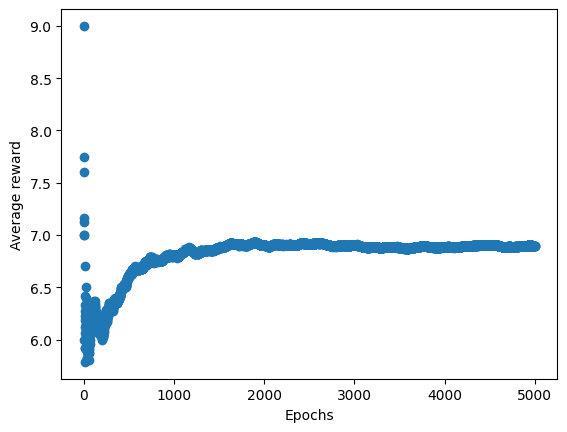

In [23]:
fig, ax = plt.subplots()
ax.scatter(np.arange(len(mean_rewards)), mean_rewards)
ax.set_ylabel("Average reward")
ax.set_xlabel("Epochs");